In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,1.65)
fontsize = 11

In [4]:
dataf = "../../data/clwbvsntstore.csv"

In [5]:
!sha256sum $dataf

4a1dd4a08ebc2e14526c06b259ef3bdb994e38090eaa0e91acca91aacb191b91  ../../data/clwbvsntstore.csv


In [6]:
flights = sns.load_dataset("flights")
flights.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
year,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
passengers,112,118,132,129,121,135,148,148,136,119,104,118,115,126,141,135,125,149,170,170,158,133,114,140,145,150,178,163,172,178,199,199,184,162,146,166,171,180,193,181,183,218,230,242,209,191,172,194,196,196,236,235,229,243,264,272,237,211,180,201,204,188,235,227,234,264,302,293,259,229,203,229,242,233,267,269,270,315,364,347,312,274,237,278,284,277,317,313,318,374,413,405,355,306,271,306,315,301,356,348,355,422,465,467,404,347,305,336,340,318,362,348,363,435,491,505,404,359,310,337,360,342,406,396,420,472,548,559,463,407,362,405,417,391,419,461,472,535,622,606,508,461,390,432


In [7]:
df = pd.read_csv(dataf, index_col=None, names=['Write size', 'Drain interval', 'CLWB+SFENCE', 'NT-Store'])

In [8]:
df_norm = df.copy(deep=True)
df_norm['Speedup'] = df['CLWB+SFENCE'] / df['NT-Store']
del df_norm['CLWB+SFENCE']
del df_norm['NT-Store']

df_norm.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Write size,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,256.000000,256.00000,256.000000,256.000000,256.000000,256.000000,256.00000,256.000000,256.000000,256.000000,512.000000,512.000000,512.000000,512.000000,512.00000,512.000000,512.000000,512.00000,512.000000,512.000000,1024.000000,1024.000000,1024.000000,1024.00000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.00000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.00000,2048.000000,2048.000000,2048.000000,2048.000000,4096.000000,4096.000000,4096.000000,4096.00000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.00000,8192.000000,8192.000000,8192.000000,8192.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.00000,32768.000000,32768.00000,32768.000000,32768.000000,32768.00000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000
Drain interval,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,256.000000,512.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,256.000000,512.000000,1.000000,2.00000,4.000000,8.000000,16.000000,32.000000,64.00000,128.000000,256.000000,512.000000,1.000000,2.000000,4.000000,8.000000,16.00000,32.000000,64.000000,128.00000,256.000000,512.000000,1.000000,2.000000,4.000000,8.00000,16.000000,32.000000,64.000000,128.000000,256.000000,512.00000,1.000000,2.000000,4.000000,8.000000,16.000000,32.00000,64.000000,128.000000,256.000000,512.000000,1.000000,2.000000,4.000000,8.00000,16.000000,32.000000,64.000000,128.000000,256.000000,512.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.00000,64.000000,128.000000,256.000000,512.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,256.000000,512.00000,1.000000,2.00000,4.000000,8.000000,16.00000,32.000000,64.000000,128.000000,256.000000,512.000000
Speedup,1.588536,2.748877,4.875945,4.469312,4.842462,4.826099,4.922771,4.804521,4.588318,4.860349,1.847945,3.284493,5.677219,6.071316,5.964884,6.026551,6.033624,6.156632,6.120729,6.168346,2.070347,3.57088,4.653073,6.531963,7.081325,7.719837,7.95103,8.098891,8.121711,8.131219,2.917758,3.420388,4.538191,4.742957,5.08198,5.227893,5.277352,5.26351,5.234015,5.282356,3.325131,4.130678,4.386943,4.70014,4.812538,4.814244,4.858356,4.887912,4.918915,4.88319,3.403445,3.690286,3.906502,3.985776,4.065114,4.04033,4.022317,4.048405,4.044184,4.052078,3.324782,3.186573,3.232386,3.22636,3.222394,3.231428,3.225834,3.202483,3.218522,3.204453,1.502309,1.536583,1.551479,1.558923,1.559331,1.56478,1.568121,1.567014,1.556132,1.560652,1.463293,1.486655,1.495949,1.502827,1.502513,1.500025,1.505132,1.498511,1.506614,1.48292,1.676906,1.72143,1.729167,1.730171,1.73518,1.739446,1.741005,1.738107,1.736095,1.738831


In [9]:
Fig.config(13, (8, 4))

Plot saved as `plots/pathfinding/clwbvsntstore.png`

Plot saved as `plots/pathfinding/clwbvsntstore.png`

Using pdfcrop on `plots/pathfinding/clwbvsntstore.png` with command `pdfcrop plots/pathfinding/clwbvsntstore.pdf plots/pathfinding/clwbvsntstore.pdf`

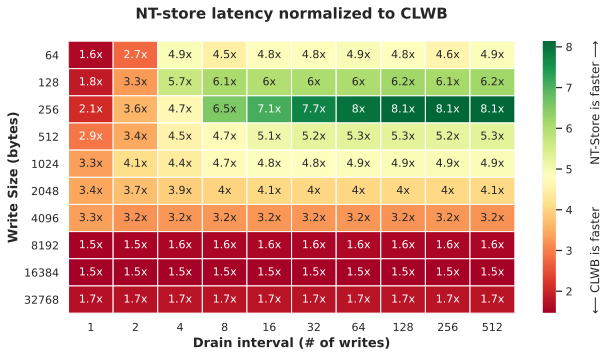

In [10]:
# define the colormap
cmap = plt.get_cmap('RdYlGn')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

df_pivot = df_norm.pivot("Write size", "Drain interval", "Speedup")
sns.set(font_scale = 1.2)
sns.set(rc={'figure.figsize':(10,5)})
g = sns.heatmap(
    df_pivot, 
    annot=True, 
    annot_kws={"size": 11, 'label': 'colorbar title'}, 
    cmap=cmap, 
#     vmin=0, 
#     vmax=2, 
    linewidths=1,
)

ax = g.axes
f = Fig(ax)
f.fmt_label('Drain interval (# of writes)', 'Write Size (bytes)')

for t in g.texts: t.set_text(t.get_text() + "x")

ax.collections[0].colorbar.set_label("\n⟵ CLWB is faster           NT-Store is faster ⟶")
ax.set_title('NT-store latency normalized to CLWB\n', fontsize=fontsize+4, fontweight='bold')

f.save('clwbvsntstore')

In [38]:
import io
_df = pd.read_csv(io.StringIO("""pmdk,snashot,msync
1309827965,1225780573,
797215151,674379518,
752649700,623836241,
907402849,776246116,
88362592,69833385,
1441963984,1348662225,
1830593014,2228177769,"""), index_col=None)

In [39]:
_df_norm = _df['pmdk']/_df['snashot']

<AxesSubplot:>

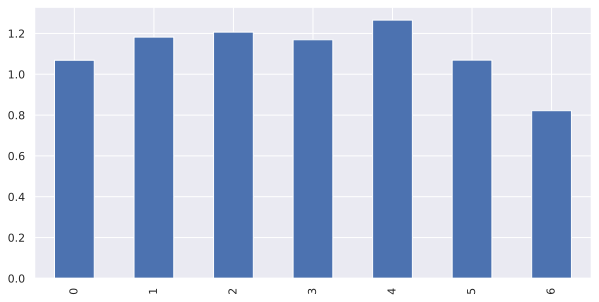

In [40]:
_df_norm.plot.bar()